# Set Up

In [8]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate
from scipy.stats import binned_statistic

# import functions stored in utils_explore.py
# from utils_explore import *


Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_30027/1577762617.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [9]:
# ions wavelenghts
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]
o3 = [4958.911,5006.843]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x_ = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x_ * pixel_size


arcsec_pixel =  pixel_scale / x_

print (Blue + "Scale: 1 arcsec is" + CEND, x_, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x_, 'x', 20.4 * x_, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc
Scale: 1 arcsec is 0.8822246804500427 kpc
Scale: 1 pixel is 0.25712967646524765 kpc
FOV for z 0.043118 is 14.556707227425704 x 17.99738348118087 kpc
Scale: 1 pixel is 0.291456 arcsec


# PATH TO FOLDERS

In [10]:
"""CHANGE THESE PATHS"""

path_1comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter3/' #This is the 1 component fit
path_2comp_fit = '/raid/KCWI/AGN_outflows/F05189/iter2/' #This is the 2 compoents fit (not OIII)
path_3comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter5/' #This is the 3 components fit

## Read Files 3 components fit

<span style="color:red">
ONLY RUN THESE CELLS IF YOU HAVE/NEED 3COMP FIT
</style>

In [11]:
data_3comp = readsav(path_3comp_fit+'F05189.xdr')
data_arr_3comp = data_3comp['windstr']
# print(data_arr_3comp.dtype.names)

lin_data_3comp = readsav(path_3comp_fit+'F05189.lin.xdr')
# print(lin_data_3comp.keys())

## Load Arrays 3 components fit

In [12]:
data_flx_3comp = lin_data_3comp['emlflx'][0][8]
data_flx_err_3comp = lin_data_3comp['emlflxerr'][0][8]
vel_arr_3comp = data_arr_3comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_3comp)):
    if data_flx_3comp[i][0] != None:
        print(i,data_flx_3comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_3comp)):
    if vel_arr_3comp[i][0] != None:
        print(i,vel_arr_3comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
1 b'fc2'
3 b'fc3pk'
4 b'fc2pk'
5 b'fc1'
6 b'fc1pk'
7 b'fc3'
####### VEL ########
0 b'v%02c3'
2 b'v%50c3'
3 b'vsigc3'
4 b'v%02c1'
5 b'v%50c1'
8 b'v%84c3'
9 b'v%98'
10 b'vsigc3err'
11 b'vsigc1'
12 b'vsigc2'
15 b'v%50'
16 b'v%50c2'
18 b'v%50c3err'
19 b'vsigc2err'
20 b'v%02c2'
24 b'v%50c1err'
27 b'v%98c1'
32 b'v%84c1'
40 b'v%98c2'
42 b'v%16c3'
43 b'v%16'
45 b'v%84c2'
46 b'vpk'
48 b'vsig'
49 b'v%02'
50 b'v%50c2err'
51 b'vsigc1err'
53 b'v%98c3'
56 b'v%16c2'
59 b'v%84'
63 b'v%16c1'


In [13]:
"""CHANGE THESE INDICES ACCORDING TO ABOVE"""

fc1_3comp_idx = 5
fc2_3comp_idx = 1
fc3_3comp_idx = 7

vsig_c1_3comp_idx = 11
v50_c1_3comp_idx = 5
v98_c1_3comp_idx = 27
v02_c1_3comp_idx = 4

vsig_c2_3comp_idx = 12
v50_c2_3comp_idx = 16
v98_c2_3comp_idx = 40
v02_c2_3comp_idx = 20

vsig_c3_3comp_idx = 3
v50_c3_3comp_idx = 2
v98_c3_3comp_idx = 53
v02_c3_3comp_idx = 0

## Total Flux 3 components fit

In [14]:
ftot_3comp = data_flx_3comp[0][1][0][8]
err_ftot_3comp = data_flx_err_3comp[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot_3comp)):
    if ftot_3comp[i][0] != None:
        print(i,ftot_3comp[i][0])

####### LINES ########
0 b'Hbeta'
3 b'[NeIII]3967'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
10 b'[NeIII]3869+[NeIII]3967'
12 b'[OII]3729'
13 b'[OIII]4959'
14 b'[OIII]5007'
15 b'Hgamma'


# Define the ION you want to explore

In [15]:
"""CHANGE ion, ion_tag AS NEEDED"""

ion = 5    #change this with the index of the ion you want
ion_tag = 'o2'    #change this in 'o2' or o3' 


"""DON'T CHANGE THESE"""
if ion_tag == 'o2':
    plot_limits = ((z+1)*o2[1] - 70, (z+1)*o2[1] + 70)
    ion_line = [b'[OII]3726', b'[OII]3729']
    ion_wave_0 = o2[0]
    ion_wave_1 = o2[1]
    vel_lim=[-2500,2500]

elif ion_tag == 'o3':
    plot_limits = ((z+1)*o3[1] - 70, (z+1)*o3[1] + 70)
    ion_line = [b'[OIII]5007']
    ion_wave_0 = o3[0]
    ion_wave_1 = o3[1]
    vel_lim=[-2500,2500]


In [16]:
"""CHANGE err_thresh AFTER FINDING IT USING THE BELOW PLOTTING FUNCTIONS"""

err_thresh =  0.0014 #set the error threshold after exploring the error arrays


# Functions to get data for maps

In [17]:
def set_sn(arr, arr2):
    sn_cut = np.where(arr < 0.1) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 5, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
    return arr   

def get_flux_uncorr(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)  
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(idx, arr):
    f_err = copy(arr[idx][1])
    f_err = set_bad(f_err)  
    return f_err
    
def get_variable(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

## Calc err_thresh

In [18]:
def err_map(idx, arr, title = None, kpc=False, arcsec=False):
    figure(figsize=(4,4))
    ax=subplot(111)
    o2_err = get_err_flux(idx, arr) 

    im = ax.imshow(o2_err, origin='lower', cmap='viridis', norm=LogNorm())
    colorbar(im)
    ax.title.set_text(title)
    
    x_tick = (17, 37, 57)
    ax.set_xticks(x_tick)
    y_tick = (27, 47, 67)
    ax.set_yticks(y_tick)    
    
    if kpc == True:
        x_labels = np.round(np.array([-20, 0 , 20])*pixel_scale,1)
        ax.set_xticklabels(x_labels,size=10)
        y_labels = np.round(np.array([-20, 0 , 20])*pixel_scale,1)
        ax.set_yticklabels(y_labels,size=10)
        #plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        ax.set_xlabel(r'kpc',fontsize=11)
        ax.set_ylabel(r'kpc',fontsize=11)
    if arcsec == True:
        x_labels = np.round(np.array([-20, 0 , 20])*arcsec_pixel,1)
        ax.set_xticklabels(x_labels,size=10)
        y_labels= np.round(np.array([-20, 0 , 20])*arcsec_pixel,1)
        ax.set_yticklabels(y_labels,size=10)
        #plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        ax.set_xlabel(r'arcsec',fontsize=11)
        ax.set_ylabel(r'arcsec',fontsize=11)
    return o2_err    

In [ ]:
##### 3comp c1##### 

%matplotlib inline
err_fc1_3comp = data_flx_err_3comp[5][1][0][8]
o2_err_3comp = err_map(ion,err_fc1_3comp, '[OII] Flux Error', kpc=True) #Error map to evaluate error threshold, no cuts
# savefig('o2_error_1comp.pdf')
#CHANGE to err_fc_1comp for 1 component fit

In [ ]:


%matplotlib inline

##### change this to whatever array you want to look at
err_temp = o2_err_3comp
#####

figure(figsize=(4,4))
ax = subplot(111)
plt.xlim(0,0.005)

index = np.where(err_temp < 0.03)
newlist_2 = err_temp[index]

ax.hist(newlist_2,bins=1000)
ax.axvline( x = 0.0035, c='orange', lw=1, ls='-')
ax.axvline( x = 0.0014, c='orange', lw=1, ls='-')
# ax.axvline( x = 0.0002, c='orange', lw=1, ls='-')

print(np.min(newlist_2), np.max(newlist_2))
# savefig('o2_errorhist_1comp.pdf')

# Functions to plot kinematics maps

In [19]:
# min and max for plots, change if something looks wonky

v50_min_c1 = -400
v50_max_c1 = 400
vsig_min_c1 = 0
vsig_max_c1 = 700
v02_min_c1 = -1000
v02_max_c1 = 300
v98_min_c1 = -300
v98_max_c1 = 1000

v50_min_c2 = -600
v50_max_c2 = 600
vsig_min_c2 = 0
vsig_max_c2 = 700
v02_min_c2 = -600
v02_max_c2 = 1000
v98_min_c2 = -2000
v98_max_c2 = 600

v50_min_c3 = -1100
v50_max_c3 = 1100
vsig_min_c3 = 0
vsig_max_c3 = 700
v02_min_c3 = -600
v02_max_c3 = 1000
v98_min_c3 = -2000
v98_max_c3 = 600

In [20]:
def plot_kin(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -400, 400,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -1000, 300,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -300, 1000,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -600, 600,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c3(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -1100, 1100,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)
    
def sub_plot(var,vmin,vmax,color_map,spx_x=None, spx_y=None, width=None, height=None,spx=False, rec= False,title=None,scale=None,  lab_x=False, lab_y=False):
    imshow(var, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax, interpolation='none')
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
    ax.title.set_text(title)  
    
    ax.set_xticks([16, 36, 56])
    ax.set_yticks([30, 50, 70]) 
    
    if scale == 'kpc':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        label = r'kpc'
    elif scale == 'arcsec':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        label = r'arcsec'
    else:
        label=r'spaxel'

    if lab_x == False: 
        ax.set_xlabel(label,fontsize=11)
    if lab_y == False:  
        ax.set_ylabel(label,fontsize=11)
 

    

# Function to get data of one spaxel

In [21]:
def get_values(idx,  f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp,  spx_x, spx_y):
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    o2 = f_temp[ion][1][spx_y][spx_x]
    o2_err = err_f_temp[ion][1][spx_y][spx_x]

    ## nat added
    # print('flux', round(f_temp[spx_y][spx_x],2))

    print('v50', round(v50_line[spx_y][spx_x],2), 'vsig', round(vsig_line[spx_y][spx_x],2), 'v02', round(v02_line[spx_y][spx_x],2), 'v98', round(v98_line[spx_y][spx_x],2))
    print('o2 flux', round(o2,4), 'o2_err', round(o2_err,4), 'SNR', round(o2/o2_err,2))
    

# Functions to Plot Fits

In [22]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        self.limits(self.wave, xmin, xmax, 2.8)

    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        self.limits(vel, vmin, vmax, 1.8)

        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        ymax = self.limits(self.wave, xmin, xmax, 1.3)
        
        if pr == True:
            plt.text(plot_limits[0]+15, ymax*0.9,  str_x + '_' + str_y, fontsize=9)
            
    def limits(self, var, _min, _max, factor):
        yi = self.speclines[(var > _min) & (var < _max)] + self.modstars[(var > _min) & (var < _max)]
        erri = self.specerr[(var > _min) & (var < _max)]
        ymax = max(factor * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(_min, _max)
        plt.ylim(ymin, ymax)
        return ymax
        
    def plot_line_vel_pdf(self, line, wave_o, z, vmin, vmax,       str_x, str_y, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave_o * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        if self.ncomp!=0:
            col = ['','0','1','2']
            for l in line:
                for i in range(1,self.ncomp+1):
                    style = 'C' + col[i] + '--'
                    plt.plot(vel, self.cmplin(l, i), style, lw=1.)
            plt.plot(vel, self.modlines, 'C3', lw=lw)
        ymax = self.limits(vel, vmin, vmax, 1.2)
        plt.axvline(0,color='k', ls='--', lw=0.5)
        if sn == True and self.ncomp!=0:
            plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
            plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
        ##nat added
        plt.text(plot_limits[0]+15, ymax*0.9,  str_x + '_' + str_y, fontsize=9)
            
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    if ion_tag == 'o2': 
        spax.plot_lines(ax, ion_line, plot_limits[0], plot_limits[1])
        ax.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        ax.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)
        if ltitle:
            ax.title.set_text('[OII]3726,9')
    elif ion_tag == 'o3':
        spax.plot_lines(ax, ion_line, plot_limits[0], plot_limits[1])
        ax.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        ax.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)
        if ltitle:
            ax.title.set_text('[OIII]5007')

def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
        spax.plot_lines_pdf(ion_line, plot_limits[0], plot_limits[1], str_x, str_y, pr)
        plt.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        plt.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)

# Functions to Plot Radial Profile 

In [23]:
def sb_profile(arr):
    a = arr/pixel_size**2
    np.nan_to_num(a, copy=False)
#     idx = np.unravel_index(np.argmax(a), a.shape)
#     print(idx, a.shape[0], a.shape[1])
    idx = (49,37)
    sb_arr = []
    radius_sb = []
    for x in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[x,j] != 0:
                sb_arr.append(a[x,j])
                radius_sb.append(math.dist(idx, (x,j))*pixel_scale)
    return(sb_arr,radius_sb)          
 

In [24]:
def sb_stat(arr, arr2, sb_range, nbins):
   
    x = np.array(arr)
    y = np.array(arr2)
   
    n, _ = np.histogram(x, bins=nbins, range=sb_range)
    sy, _ = np.histogram(x, bins=nbins, weights=y, range=sb_range)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y, range=sb_range)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
   
    return(mean,std,_)


# Spaxel to investigate

In [25]:
spx_x = 39
spx_y = 45

In [26]:
custom_xlim = (2, 70)
custom_ylim = (16, 84)

# 3 Component Fit

## c1 in 3comp fit

In [27]:
fc1_3comp = data_flx_3comp[fc1_3comp_idx][1][0][8]
err_fc1_3comp = data_flx_err_3comp[fc1_3comp_idx][1][0][8]

vsig_c1_3comp = vel_arr_3comp[vsig_c1_3comp_idx][1][0][8]
v50_c1_3comp = vel_arr_3comp[v50_c1_3comp_idx][1][0][8]
v98_c1_3comp = vel_arr_3comp[v98_c1_3comp_idx][1][0][8]
v02_c1_3comp = vel_arr_3comp[v02_c1_3comp_idx][1][0][8]


snr_c1_3comp = get_sn(ion,fc1_3comp,err_fc1_3comp)

### v_50 histogram

(-200.0, 200.0)

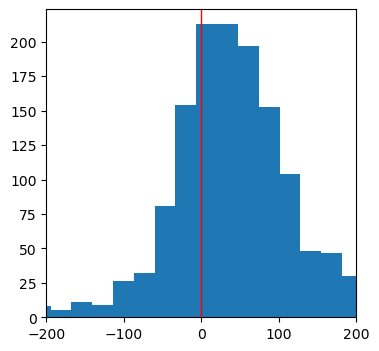

In [20]:
%matplotlib inline
figure(figsize=(4,4))
ax = subplot(111)

v_50_3comp_hist = get_variable(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp)
test_list = v_50_3comp_hist.flatten()
test_list = [x for x in test_list if str(x) != 'nan']

ax.hist(test_list,bins=100)
ax.axvline( x = 0, c='red', lw=1, ls='-')


ax.set_xlim(-200,200)
# savefig(ion_tag + '_' +'c1_v50_hist.pdf')

In [21]:
spaxel_test = get_values(ion,fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, spx_x, spx_y)

v50 -3.58 vsig 148.47 v02 293.36 v98 -300.51
o2 flux 0.6559 o2_err 0.1378 SNR 4.76


SNR = 4.76 v50 = -3.58


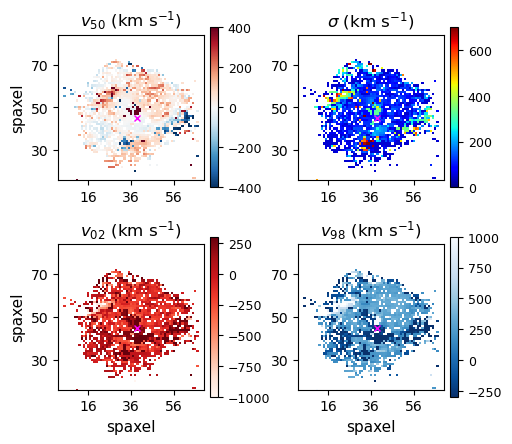

In [22]:
%matplotlib inline
plot_kin(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc1_3comp[ion][1][spx_y][spx_x]/err_fc1_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c1_3comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'kinematics_c1_3comp.pdf')


In [36]:
### set up stuff for radial plots

def build_wave(hdu_hdr, air2vac=True):
    """
    Args:
        hdu_hdr:
    Returns:
        wave: ndarray
    """
    crval3 = hdu_hdr['CRVAL3']
    crpix3 = hdu_hdr['CRPIX3']
    cd3_3 = hdu_hdr['CD3_3']
    wavedim = hdu_hdr['NAXIS3']
    wave = crval3 + cd3_3 * (np.arange(wavedim) + 1. - crpix3)
    # Air2vac?
    if air2vac:
        wave = airtovac(wave)
    return wave

hdu = fits.open('/raid/KCWI/AGN_outflows/mosaics/F05189_mosaic.fits')
header = hdu[0].header
wave_cube = build_wave(header, air2vac=False) #air wavelenght, CHANGE to air2vac = True for vacuum
wave_cube = wave_cube

flux_cont = hdu[0].data
flux_cont = flux_cont.T

################### CHANGE THIS after looking at QFitsView
index = np.where(((wave_cube > 4320) & (wave_cube < 4490)) | ((wave_cube > 4570) & (wave_cube < 4850)) ) #wavelength range to integrate the stellar continuum

star_cont = np.zeros(flux_cont.T[0].shape)

for j in range(0,len(flux_cont)):
    for x in range(0,len(flux_cont[0])):
        continuum_sum = flux_cont[j][x][index]
        star_cont[x][j] = np.sum(continuum_sum)

################ CHANGE CENTER
center_y = 49
center_x = 37 
        
def sb_profile(arr,manual=False):
    a = arr/pixel_size**2
    if manual == False:
        idx = np.unravel_index(np.argmax(a), a.shape)
        print('to check', idx, a.shape[0], a.shape[1])
    else:
        idx = (center_y,center_x)
        print('idx set to', idx)
   
    sb_arr = []
    radius_sb = []
    for x in range(a.shape[0]):
        for j in range(a.shape[1]):
            if (a[x,j]!=0 and str(a[x,j]) != 'nan'):
                sb_arr.append(a[x,j])
                radius_sb.append(math.dist(idx, (x,j))*pixel_scale)
    return(sb_arr,radius_sb)          



In [46]:
%matplotlib notebook
from scipy.stats import norm

def sb_stat(arr, arr2, sb_range, nbins):
   
    x = np.array(arr)
    y = np.array(arr2)
   
    n, _ = np.histogram(x, bins=nbins, range=sb_range)
    sy, _ = np.histogram(x, bins=nbins, weights=y, range=sb_range)
    sy2, _ = np.histogram(x, bins=nbins, weights=y*y, range=sb_range)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
   
    return(mean,std,_)

def plot_sb_profile(rad, sb, mean, std, maxx_norm, log_ = False):
    figure(figsize=(6,6))
    ax = gca()

    ax.scatter(rad, sb,  color='black', marker='.', s=25, label = '[OII] data')

    plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='s',markersize=5,ls='none',capsize=3, label = '[OII] average', color='darkturquoise')
    plt.errorbar((_star[1:] + _star[:-1])/2, mean_star, yerr=std_star, fmt='s',markersize=5,ls='none',capsize=3, label = 'stellar average', color='mediumslateblue')

    ax.errorbar(np.array(rad_seeing), norm.pdf(rad_seeing,0,seeing_kpc)/maxx*maxx_norm,ls='-.', c='orange', label='seeing')#/maxx*2.6


    ax.set_xlabel(r'Radius (kpc)',fontsize=13)  #Sets the x axis label
    ax.set_ylabel(r'Surface Brightness  $(10^{-16} \, erg \, s^{-1} cm^{-2} \, arcsec^{-2})$',fontsize=13) #Sets the y axis label

    if log_ == True:
        plt.xlim(0.2,10)
        plt.ylim(0.02,45) ############# CHANGE THIS
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.legend(loc='lower left',ncol=1,prop={'weight':'bold'})
#         savefig(target + 'sb_radial_profile_log.pdf', bbox_inches='tight')

    else:
        plt.xlim(plot_range)
        plt.ylim(-1,maxx_norm + 10)
        plt.legend(loc='upper right',ncol=1,prop={'weight':'bold'})
#         savefig(target + 'sb_radial_profile.pdf', bbox_inches='tight')

nbins = 10 # Change here the number of bins
rad_plot = 7 # Change here the maximum radius where you have your flux
sb_range = (0, rad_plot)
plot_range = (-0.3, rad_plot) # Range of the x-axis
seeing_kpc = 0.6 * x_ /2 # Change here the seeing in arcseconds

rad_seeing = np.arange(-0.5,rad_plot,0.1)
maxx = np.max(norm.pdf(rad_seeing,0,seeing_kpc)) # Maximum values of the Gaussian



idx set to (49, 37)
to check (48, 37) 97 74


<IPython.core.display.Javascript object>


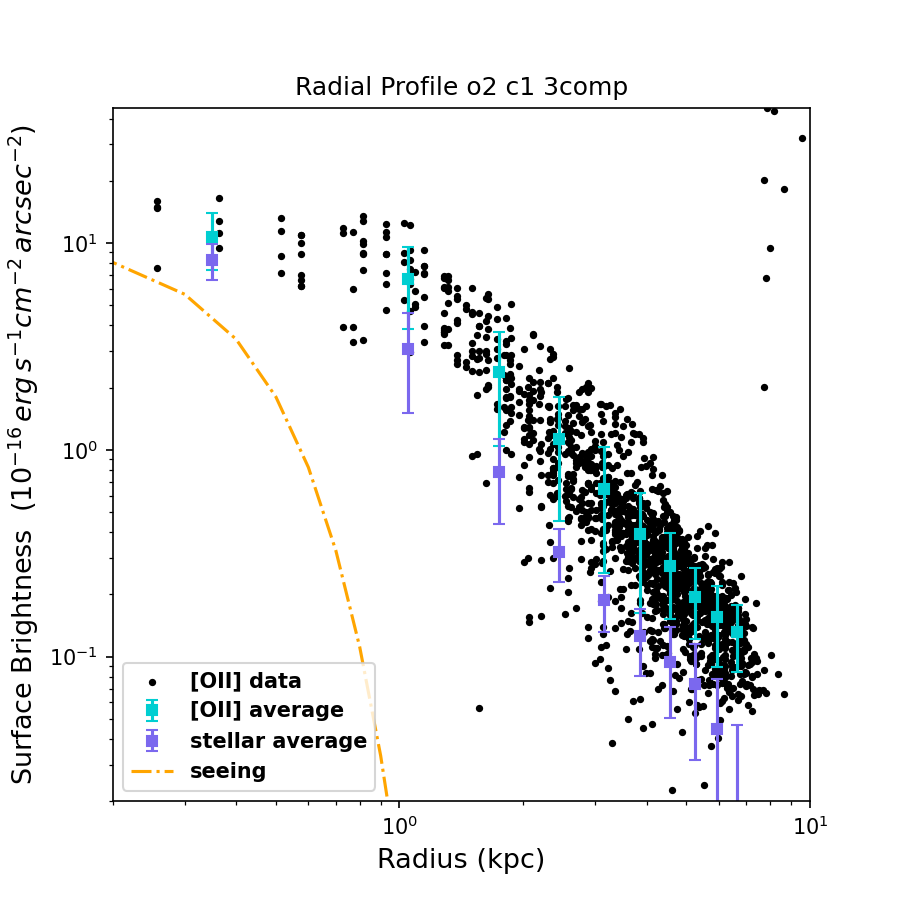

In [48]:
### c1
%matplotlib notebook
##################### rmb to make SN cut ~0.1
o2_flux_c1 =  get_flux_uncorr(ion, fc1_3comp, err_fc1_3comp) 

sb_arr_c1,radius_sb_c1 = sb_profile(o2_flux_c1, manual = True) # manual = True when there are random spaxels with high SB values
sb_arr_star_c1,radius_sb_star_c1 = sb_profile(star_cont)

maxx_star_c1 = np.max(sb_arr_star_c1) # Maximum values of the stellar SB
mean_c1, std_c1, _ = sb_stat(radius_sb_c1, sb_arr_c1, sb_range, nbins)
maxx_norm_c1 = mean_c1[0] # Maximum value of the SB
mean_star_c1, std_star_c1, _star = sb_stat(radius_sb_star_c1, sb_arr_star_c1/maxx_star_c1*maxx_norm_c1, sb_range, nbins)

plot_sb_profile(radius_sb_c1, sb_arr_c1, mean_c1, std_c1, maxx_norm_c1, log_ = True)
plt.title(f'Radial Profile {ion_tag} c1 3comp')
# plt.savefig(f'{ion_tag}_radprofile_c1_3comp.png')



## c2 in 3comp fit

In [41]:
fc2_3comp = data_flx_3comp[fc2_3comp_idx][1][0][8]
err_fc2_3comp = data_flx_err_3comp[fc2_3comp_idx][1][0][8]

vsig_c2_3comp = vel_arr_3comp[vsig_c2_3comp_idx][1][0][8]
v50_c2_3comp = vel_arr_3comp[v50_c2_3comp_idx][1][0][8]
v98_c2_3comp = vel_arr_3comp[v98_c2_3comp_idx][1][0][8]
v02_c2_3comp = vel_arr_3comp[v02_c2_3comp_idx][1][0][8]


snr_c2_3comp = get_sn(ion,fc2_3comp,err_fc2_3comp)

In [36]:
spaxel_test = get_values(ion,fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, spx_x, spx_y)

v50 nan vsig nan v02 nan v98 nan
o2 flux 0.109 o2_err 0.0895 SNR 1.22


<IPython.core.display.Javascript object>


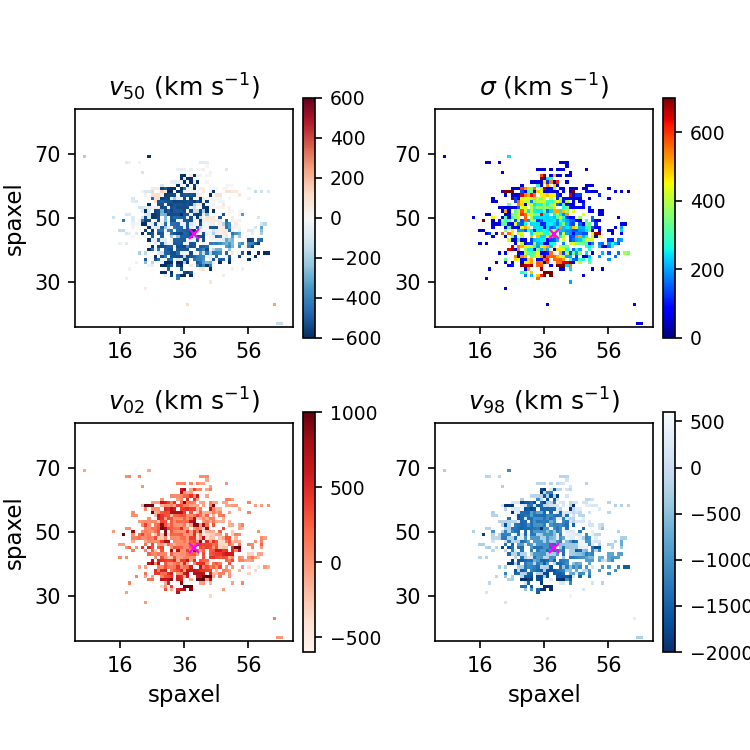

SNR = 1.22 v50 = -27.95


In [37]:
%matplotlib notebook
plot_kin_c2(ion, fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc2_3comp[ion][1][spx_y][spx_x]/err_fc2_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c2_3comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'kinematics_c2_3comp.pdf')


idx set to (49, 37)
to check (48, 37) 97 74


<IPython.core.display.Javascript object>


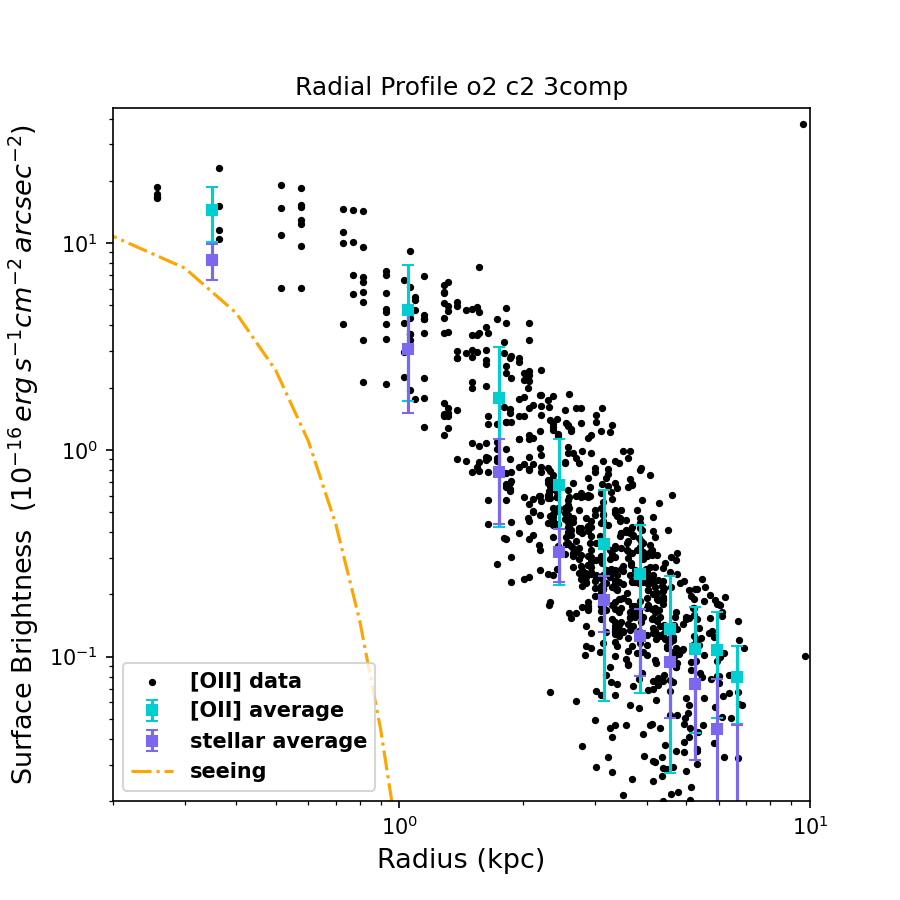

In [50]:
### c2
%matplotlib notebook

o2_flux_c2 =  get_flux_uncorr(ion, fc2_3comp, err_fc2_3comp) 

sb_arr_c2,radius_sb_c2 = sb_profile(o2_flux_c2, manual = True) # manual = True when there are random spaxels with high SB values
sb_arr_star_c2,radius_sb_star_c2 = sb_profile(star_cont)

maxx_star_c2 = np.max(sb_arr_star_c2) # Maximum values of the stellar SB
mean_c2, std_c2, _ = sb_stat(radius_sb_c2, sb_arr_c2, sb_range, nbins)
#### REORDERED TO HERE
maxx_norm_c2 = mean_c2[0] # Maximum value of the SB
mean_star_c2, std_star_c2, _star = sb_stat(radius_sb_star_c2, sb_arr_star_c2/maxx_star_c2*maxx_norm_c2, sb_range, nbins)

plot_sb_profile(radius_sb_c2, sb_arr_c2, mean_c2, std_c2, maxx_norm_c2, log_ = True)
plt.title(f'Radial Profile {ion_tag} c2 3comp')
# plt.savefig(f'{ion_tag}_radprofile_c2_3comp.png')




## c3 in 3comp fit

In [43]:
fc3_3comp = data_flx_3comp[fc3_3comp_idx][1][0][8]
err_fc3_3comp = data_flx_err_3comp[fc3_3comp_idx][1][0][8]

vsig_c3_3comp = vel_arr_3comp[vsig_c3_3comp_idx][1][0][8]
v50_c3_3comp = vel_arr_3comp[v50_c3_3comp_idx][1][0][8]
v98_c3_3comp = vel_arr_3comp[v98_c3_3comp_idx][1][0][8]
v02_c3_3comp = vel_arr_3comp[v02_c3_3comp_idx][1][0][8]


snr_c3_3comp = get_sn(ion,fc3_3comp,err_fc3_3comp)

In [67]:
spaxel_test = get_values(ion,fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, spx_x, spx_y)

v50 -547.87 vsig 393.56 v02 239.25 v98 -1334.99
o2 flux 0.2265 o2_err 0.0177 SNR 12.81


<IPython.core.display.Javascript object>


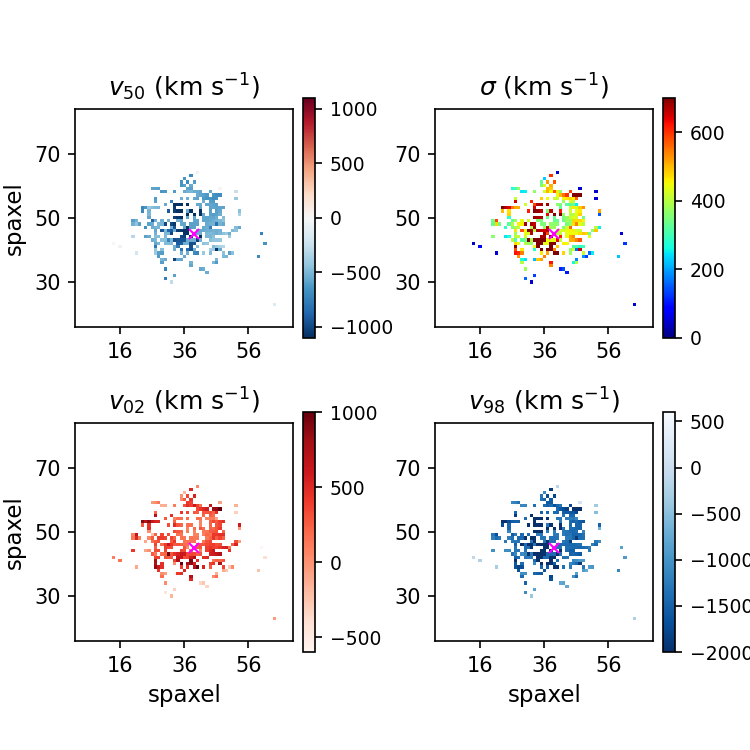

SNR = 12.81 v50 = -547.87


In [71]:
%matplotlib notebook
plot_kin_c3(ion, fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc3_3comp[ion][1][spx_y][spx_x]/err_fc3_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c3_3comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'kinematics_c3_3comp.pdf')


idx set to (49, 37)
to check (48, 37) 97 74


<IPython.core.display.Javascript object>


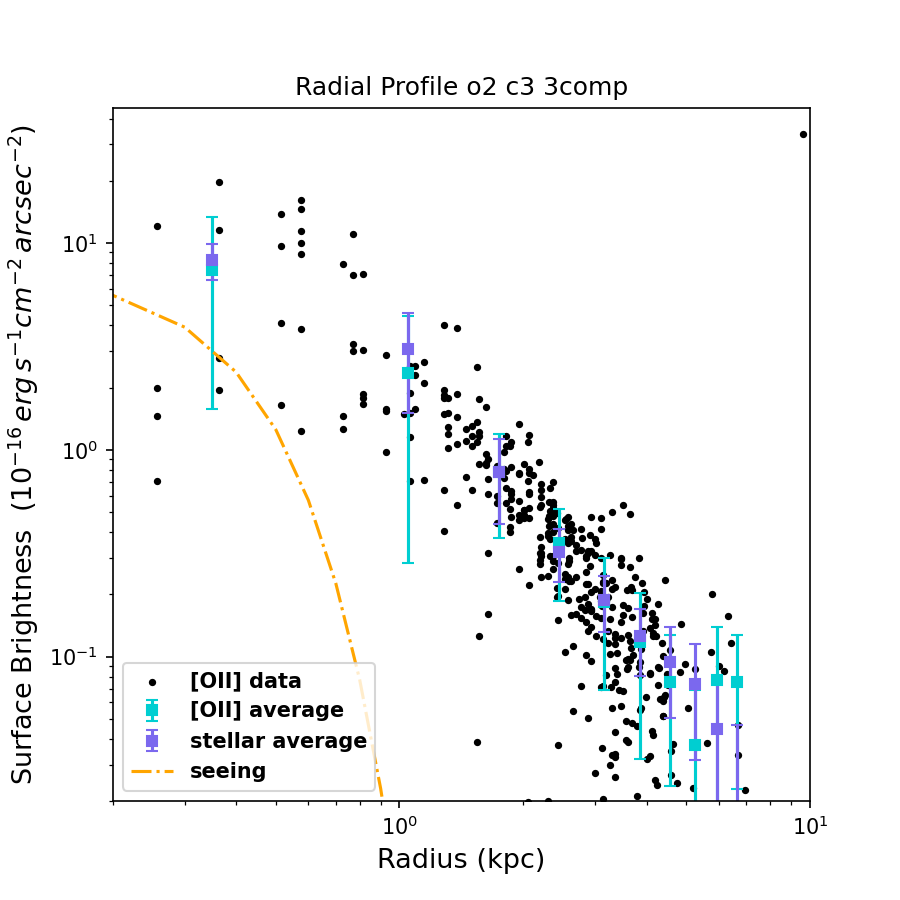

In [52]:
### c3
%matplotlib notebook

o2_flux_c3 =  get_flux_uncorr(ion, fc3_3comp, err_fc3_3comp) 

sb_arr_c3,radius_sb_c3 = sb_profile(o2_flux_c3, manual = True) # manual = True when there are random spaxels with high SB values
sb_arr_star_c3,radius_sb_star_c3 = sb_profile(star_cont)

maxx_star_c3 = np.max(sb_arr_star_c3) # Maximum values of the stellar SB
mean_c3, std_c3, _ = sb_stat(radius_sb_c3, sb_arr_c3, sb_range, nbins)
#### REORDERED TO HERE
maxx_norm_c3 = mean_c3[0] # Maximum value of the SB
mean_star_c3, std_star_c3, _star = sb_stat(radius_sb_star_c3, sb_arr_star_c3/maxx_star_c3*maxx_norm_c3, sb_range, nbins)

plot_sb_profile(radius_sb_c3, sb_arr_c3, mean_c3, std_c3, maxx_norm_c3, log_ = True)
plt.title(f'Radial Profile {ion_tag} c3 3comp')
# plt.savefig(f'{ion_tag}_radprofile_c3_3comp.png')



## c1 vs c2 in 3comp fit

<IPython.core.display.Javascript object>


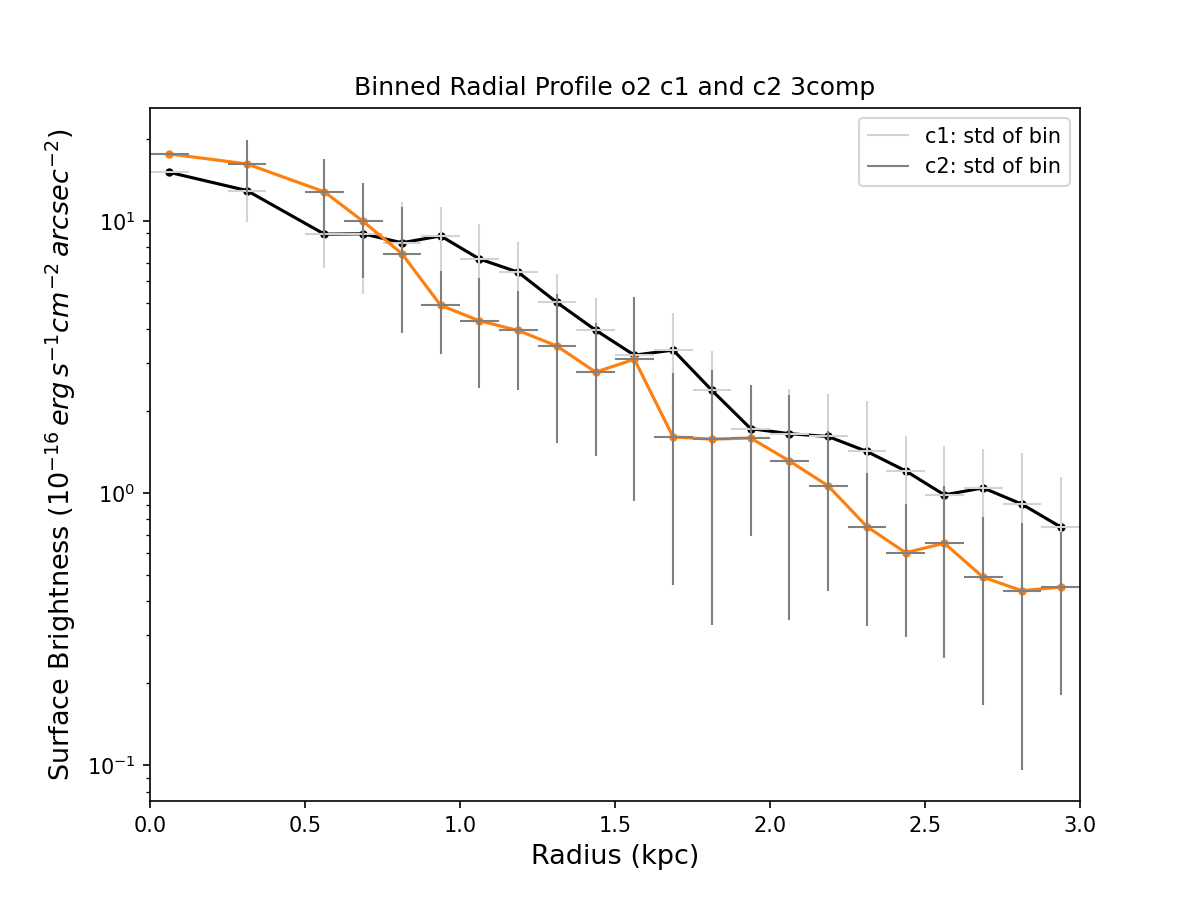

/tmp/ipykernel_4662/803743442.py:16: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')


In [74]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(bin_centers_c1[~np.isnan(bin_means_c1)], bin_means_c1[~np.isnan(bin_means_c1)], '.-', color='black')
ax.hlines(bin_means_c1, bin_edges_c1[:-1], bin_edges_c1[1:], colors='lightgray', lw=1)
ax.vlines(bin_centers_c1, bin_means_c1-bin_std_c1, bin_means_c1+bin_std_c1, colors='lightgray', lw=1, label='c1: std of bin')

ax.plot(bin_centers_c2[~np.isnan(bin_means_c2)], bin_means_c2[~np.isnan(bin_means_c2)], '.-', color='C1')
ax.hlines(bin_means_c2, bin_edges_c2[:-1], bin_edges_c2[1:], colors='gray', lw=1)
ax.vlines(bin_centers_c2, bin_means_c2-bin_std_c2, bin_means_c2+bin_std_c2, colors='gray', lw=1, label='c2: std of bin')

ax.set_xlabel(r'Radius (kpc)',fontsize=13)  #Sets the x axis label
ax.set_ylabel(r'Surface Brightness $(10^{-16} \, erg \, s^{-1} cm^{-2} \, arcsec^{-2})$',fontsize=13) #Sets the y axis label
ax.set_xlim(0,3)
ax.set_yscale('Log')
ax.set_title(f'Binned Radial Profile {ion_tag} c1 and c2 3comp')
plt.legend()
# plt.savefig(ion_tag + '_binnedradialprofile_' + 'c1c2' + '_3comp.png')


## c1 vs c3 in 3comp fit

<IPython.core.display.Javascript object>


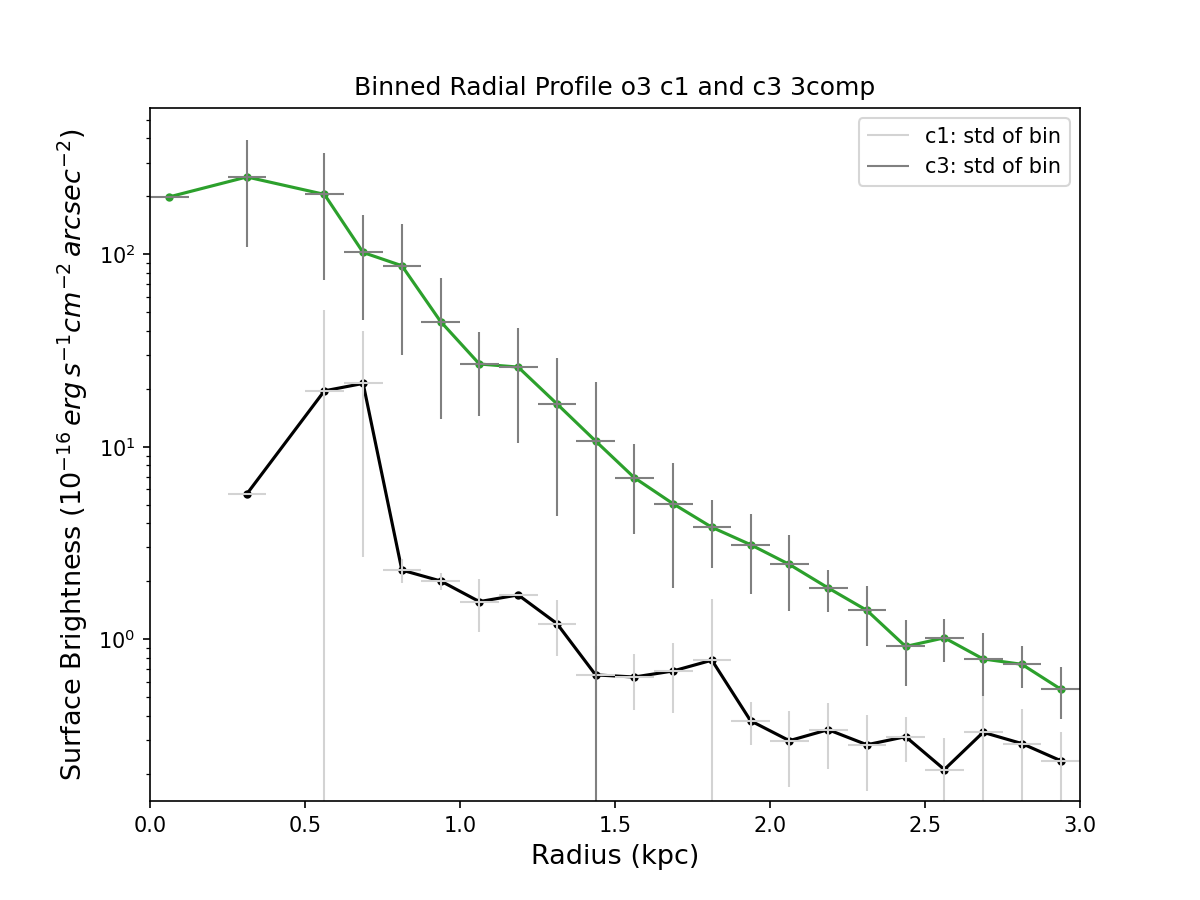

/tmp/ipykernel_4662/2450380110.py:16: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')


In [41]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(bin_centers_c1[~np.isnan(bin_means_c1)], bin_means_c1[~np.isnan(bin_means_c1)], '.-', color='black')
ax.hlines(bin_means_c1, bin_edges_c1[:-1], bin_edges_c1[1:], colors='lightgray', lw=1)
ax.vlines(bin_centers_c1, bin_means_c1-bin_std_c1, bin_means_c1+bin_std_c1, colors='lightgray', lw=1, label='c1: std of bin')

ax.plot(bin_centers_c3[~np.isnan(bin_means_c3)], bin_means_c3[~np.isnan(bin_means_c3)], '.-', color='C2')
ax.hlines(bin_means_c3, bin_edges_c3[:-1], bin_edges_c3[1:], colors='gray', lw=1)
ax.vlines(bin_centers_c3, bin_means_c3-bin_std_c3, bin_means_c3+bin_std_c3, colors='gray', lw=1, label='c3: std of bin')

ax.set_xlabel(r'Radius (kpc)',fontsize=13)  #Sets the x axis label
ax.set_ylabel(r'Surface Brightness $(10^{-16} \, erg \, s^{-1} cm^{-2} \, arcsec^{-2})$',fontsize=13) #Sets the y axis label
ax.set_xlim(0,3)
ax.set_yscale('Log')
ax.set_title(f'Binned Radial Profile {ion_tag} c1 and c3 3comp')
plt.legend()
# plt.savefig(ion_tag + '_binnedradialprofile_' + 'c1c3' + '_3comp.png')


## c2 vs c3 in 3comp fit

<IPython.core.display.Javascript object>


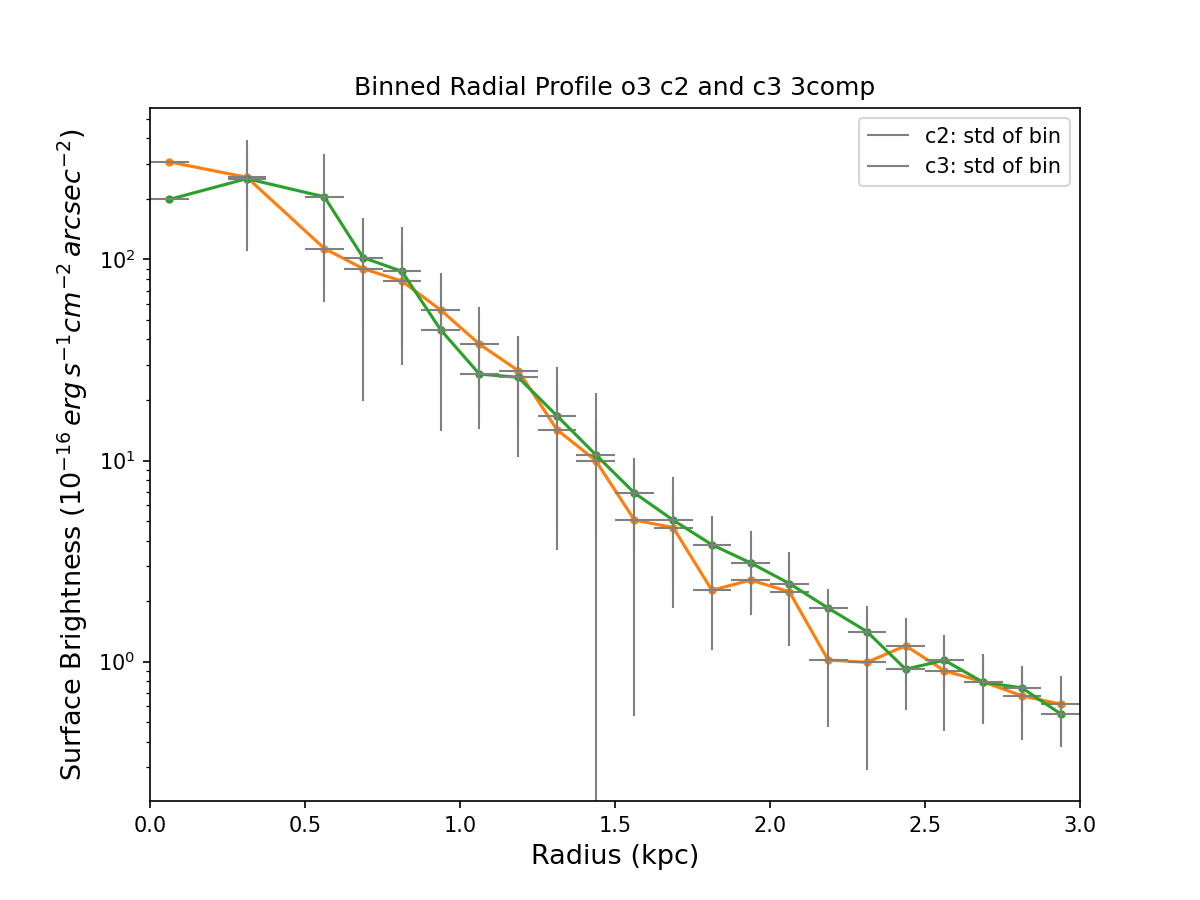

/tmp/ipykernel_4662/2862526347.py:16: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')


In [43]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(bin_centers_c2[~np.isnan(bin_means_c2)], bin_means_c2[~np.isnan(bin_means_c2)], '.-', color='C1')
ax.hlines(bin_means_c2, bin_edges_c2[:-1], bin_edges_c2[1:], colors='gray', lw=1)
ax.vlines(bin_centers_c2, bin_means_c2-bin_std_c2, bin_means_c2+bin_std_c2, colors='gray', lw=1, label='c2: std of bin')

ax.plot(bin_centers_c3[~np.isnan(bin_means_c3)], bin_means_c3[~np.isnan(bin_means_c3)], '.-', color='C2')
ax.hlines(bin_means_c3, bin_edges_c3[:-1], bin_edges_c3[1:], colors='gray', lw=1)
ax.vlines(bin_centers_c3, bin_means_c3-bin_std_c3, bin_means_c3+bin_std_c3, colors='gray', lw=1, label='c3: std of bin')

ax.set_xlabel(r'Radius (kpc)',fontsize=13)  #Sets the x axis label
ax.set_ylabel(r'Surface Brightness $(10^{-16} \, erg \, s^{-1} cm^{-2} \, arcsec^{-2})$',fontsize=13) #Sets the y axis label
ax.set_xlim(0,3)
ax.set_yscale('Log')
ax.set_title(f'Binned Radial Profile {ion_tag} c2 and c3 3comp')
plt.legend()
# plt.savefig(ion_tag + '_binnedradialprofile_' + 'c2c3' + '_3comp.png')


# Plot Maps and File region with fits

In [ ]:
x_y_start = [32,43]
x_y_end = [40,52]

size_x = x_y_end[0] - x_y_start[0] + 1
size_y = x_y_end[1] - x_y_start[1] + 1

In [ ]:
%matplotlib notebook
plot_kin(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_first_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

In [ ]:
%matplotlib notebook
plot_kin_c2(ion, fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_second_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

In [ ]:
%matplotlib notebook
plot_kin_c3(ion, fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_second_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

f = list(zip(x_y_start, x_y_end))

"""UNCOMMENT AND CHANGE THE FILE NAME"""
# pdf = PdfPages( ion_tag + '_' + 'fits' + '_3comp_' +str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

wind = 0
for x in range(0,size_x):
    for y in range(0,size_y):
        
        if wind == 0:
               fig = plt.figure(figsize=(8.5,10.0))
               gs = gridspec.GridSpec(4,4)
               gs.update(left=0.12, right=0.90, top=0.98, bottom=0.08,hspace=0.08)
        ax1 = plt.subplot(gs[wind,0])        
        ne = Spaxel(path_2comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1), pr= True)
        ax1.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax2 = plt.subplot(gs[wind,1])        
        ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1))
        plt.yticks(())
        ax2.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax3 = plt.subplot(gs[wind,2])        
        ne = Spaxel(path_2comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')   
        ne.plot_line_vel_pdf(ion_line, ion_wave_1, z, vel_lim[0], vel_lim[1]        ,str(x_y_start[0]+x+1),str(x_y_start[1]+y+1)) #, snr_c1[x_y_start[1]+y][x_y_start[0]+x], snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)

        plt.yticks(())
        ax3.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax4 = plt.subplot(gs[wind,3])        
        ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
        ne.plot_line_vel_pdf(ion_line, ion_wave_1, z,  vel_lim[0], vel_lim[1]       ,str(x_y_start[0]+x+1),str(x_y_start[1]+y+1)) #, snr_c1[x_y_start[1]+y][x_y_start[0]+x], snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)
        ax4.yaxis.set_label_position('right')
        ax4.yaxis.tick_right()
        ax4.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
        
        
        if wind == 3:
            plt.savefig(pdf, format='pdf',bbox_inches='tight')
            plt.close()
            wind = 0
        else:
            wind = wind + 1

if wind == 1 or wind == 2 or wind == 3:
    plt.savefig(pdf, format='pdf',bbox_inches='tight')
    plt.close()
pdf.close()    
        

In [ ]:
data = readsav(path_2comp_fit + 'F05189_00' + str(45) +'_00'+ str(45) + '.xdr')
print(data['struct']['parinfo'][0]['line'])
print(data['struct']['parinfo'][0]['comp'])

In [ ]:
data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/' + 'F05189_00' + str(45) +'_00'+ str(45) + '.xdr')
print(data['struct']['parinfo'][0]['line'])

# Natalie plotting

In [ ]:
# plot_kin(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False)

# plot_kin_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False)
    

In [ ]:
def get_variable_OIII(idx_f, idx_v, arr, arr2, arr3):
    f = copy(arr[idx_f][1])
    f_err = copy(arr2[idx_f][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx_v][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

In [ ]:
###### idx_f and idx_v

def plot_kin_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -400, 400,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -1000, 300,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -300, 1000,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c2_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -300, 300,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)
    
def sub_plot(var,vmin,vmax,color_map,spx_x=None, spx_y=None, width=None, height=None,spx=False, rec= False,title=None,scale=None,  lab_x=False, lab_y=False):
    imshow(var, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax, interpolation='none')
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
    ax.title.set_text(title)  
    
    ax.set_xticks([16, 36, 56])
    ax.set_yticks([30, 50, 70]) 
    
    if scale == 'kpc':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        label = r'kpc'
    elif scale == 'arcsec':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        label = r'arcsec'
    else:
        label=r'spaxel'

    if lab_x == False: 
        ax.set_xlabel(label,fontsize=11)
    if lab_y == False:  
        ax.set_ylabel(label,fontsize=11)
 


In [ ]:
### plotting 1comp

%matplotlib inline
plot_kin_OIII(13, 14, fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp)


In [ ]:
### plotting c1

%matplotlib notebook
plot_kin_OIII(13, 14, fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1)
#  err_thresh = 0.0035

In [ ]:
### plotting c2

%matplotlib inline
plot_kin_c2_OIII(13, 14, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2)


In [ ]:
%matplotlib notebook

figure(figsize=(4,4))
ax = subplot(111)
im = ax.imshow(vsig_c1[13][1], origin='lower', cmap='jet')

# Paths 

In [1]:
fits_file_path = '/raid/KCWI/AGN_outflows/F05189/F05189_3comp_switched-v98blueshift.fits'

# Functions to plot kinematics from FITS

In [2]:
def set_sn(arr, arr2):
    sn_thresh = 0.1  ###change here the SN threshold, now set to 3
    sn_cut = np.where(arr < sn_thresh) 
    arr2[sn_cut] = nan   #if the SN is less than 5, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
    return arr  

def get_variable(f_arr, ferr_arr, var_arr):
    f = copy(f_arr)
    f_err = copy(ferr_arr)
    f = set_bad(f)
    f_err = set_bad(f_err)
    
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(var_arr)
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(f_arr, ferr_arr):
    f = copy(f_arr)
    f_err = copy(ferr_arr)
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

In [3]:
def sub_plot(var, vmin, vmax, color_map,
             spx_x=None, spx_y=None, width=None, height=None, spx=False, rec= False, title=None, scale=None, lab_x=False, lab_y=False):
    
    imshow(var, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax, interpolation='none')
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
    ax.title.set_text(title)  
    
    ax.set_xticks([16, 36, 56])
    ax.set_yticks([30, 50, 70]) 
    
    if scale == 'kpc':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        label = r'kpc'
    elif scale == 'arcsec':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        label = r'arcsec'
    else:
        label=r'spaxel'

    if lab_x == False: 
        ax.set_xlabel(label,fontsize=11)
    if lab_y == False:  
        ax.set_ylabel(label,fontsize=11)

        
        
### plot c1        
def plot_kin(f_temp, ferr_temp, v50_temp, vsig_temp, v02_temp, v98_temp, 
             spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    
    figure(figsize=(5,5))
    
    v50_line = get_variable(f_temp, ferr_temp, v50_temp)
    vsig_line = get_variable(f_temp, ferr_temp, vsig_temp)
    v02_line = get_variable(f_temp, ferr_temp, v02_temp)
    v98_line = get_variable(f_temp, ferr_temp, v98_temp)
    
    subplot(221)
    sub_plot(v50_line, -400, 400,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -1000, 300,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -300, 1000,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

### plot c2
def plot_kin_c2(f_temp, ferr_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(f_temp, ferr_temp, v50_temp)
    vsig_line = get_variable(f_temp, ferr_temp, vsig_temp)
    v02_line = get_variable(f_temp, ferr_temp, v02_temp)
    v98_line = get_variable(f_temp, ferr_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -600, 600,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

### plot c3
def plot_kin_c3(f_temp, ferr_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(f_temp, ferr_temp, v50_temp)
    vsig_line = get_variable(f_temp, ferr_temp, vsig_temp)
    v02_line = get_variable(f_temp, ferr_temp, v02_temp)
    v98_line = get_variable(f_temp, ferr_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -1100, 1100,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)


    

In [4]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


In [5]:
with fits.open(fits_file_path) as hdul:
    print(hdul[1].columns)

ColDefs(
    name = 'ftot'; format = '74D'
    name = 'fc1'; format = '74D'
    name = 'fc2'; format = '74D'
    name = 'fc3'; format = '74D'
    name = 'err_ftot'; format = '74D'
    name = 'err_fc1'; format = '74D'
    name = 'err_fc2'; format = '74D'
    name = 'err_fc3'; format = '74D'
    name = 'vsig_tot'; format = '74D'
    name = 'v50_tot'; format = '74D'
    name = 'v98_tot'; format = '74D'
    name = 'v02_tot'; format = '74D'
    name = 'vsig_c1'; format = '74D'
    name = 'v50_c1'; format = '74D'
    name = 'v98_c1'; format = '74D'
    name = 'v02_c1'; format = '74D'
    name = 'vsig_c2'; format = '74D'
    name = 'v50_c2'; format = '74D'
    name = 'v98_c2'; format = '74D'
    name = 'v02_c2'; format = '74D'
    name = 'vsig_c3'; format = '74D'
    name = 'v50_c3'; format = '74D'
    name = 'v98_c3'; format = '74D'
    name = 'v02_c3'; format = '74D'
    name = 'switchinfo'; format = '74D'
)


In [6]:
ion_idx = 1

with fits.open(fits_file_path) as hdul:
    
    data = hdul[ion_idx].data
    
    ftot_3comp = data[0]
    fc1_3comp = data[1]
    fc2_3comp = data[2]
    fc3_3comp = data[3]
    err_tot_3comp = data[4]
    err_fc1_3comp = data[5]
    err_fc2_3comp = data[6]
    err_fc3_3comp = data[7]

    vsig_tot_3comp = data[8]
    v50_tot_3comp = data[9]
    v98_tot_3comp = data[10]
    v02_tot_3comp = data[11]

    vsig_c1_3comp = data[12]
    v50_c1_3comp = data[13]
    v98_c1_3comp = data[14]
    v02_c1_3comp = data[15]

    vsig_c2_3comp = data[16]
    v50_c2_3comp = data[17]
    v98_c2_3comp = data[18]
    v02_c2_3comp = data[19]

    vsig_c3_3comp = data[20]
    v50_c3_3comp = data[21]
    v98_c3_3comp = data[22]
    v02_c3_3comp = data[23]
    
    switchinfo_3comp = data[24]
    


In [7]:
%matplotlib inline

plot_kin(fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp)
    

NameError: name 'figure' is not defined